In [83]:
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn import metrics
import numpy as np
sns.set(style='ticks', font_scale=1)
import scipy.integrate
from statannotations.Annotator import Annotator
from matplotlib import pyplot as plt

# Estimate the reduction in growth rates caused by the release in the knockout mutants

In [84]:
label_mapping = {
    'aceE-M2': 'ΔaceE-M2',
    'aceE-M3': 'ΔaceE-M3',
    'aceE-M4': 'ΔaceE-M4',
    'WT': 'E. coli WT',
    'aceE': 'ΔaceE',
    'sucB-M5': 'ΔsucB-M5',
    'sucB-M6': 'ΔsucB-M6',
    'sucB-M7': 'ΔsucB-M7',
    'sucB': 'ΔsucB',
}
tab10_cmap = sns.color_palette("tab10", 10)

set2 = sns.color_palette("Set2", 8)
strains_cmap = {
    'ΔaceE': tab10_cmap[1],
    'ΔsucB': tab10_cmap[8],
    'E. coli WT': tab10_cmap[0],
    'ΔaceE-M2':set2[3],
    'ΔaceE-M3':set2[0],
    'ΔaceE-M4':set2[6],
    'ΔsucB-M5':set2[5],
    'ΔsucB-M6':set2[2],
    'ΔsucB-M7':set2[7],
}

# Estimate rate

In [85]:
git_folder = Path('../..')
figure_folder = git_folder / 'Figures' /'chemostat'


data_folder_1 = git_folder / 'data' / 'this_project' / '3_keio_strains_chemostat'
fn_tubes = data_folder_1 / '3E_exometabolome_sucB_aceE_strains_OD.csv'
fn_tube_samples = data_folder_1 / '3F_exometabolome_sucB_aceE_strains_samples.csv'
df_tubes = pd.read_csv(fn_tubes)
df_samples = pd.read_csv(fn_tube_samples)

df_tubes.rename(columns={'Hours': 'Time [h]'}, inplace=True)
df_samples.rename(columns={'Hours': 'Time [h]'}, inplace=True)

In [86]:
# aceE_abbrv = ['WT', 'aceE', 'aceE-M2', 'aceE-M3', 'aceE-M4']
auc_data = []
for abbrv in df_samples['Strain abbrv.'].unique():
    for rep in 'ABC':
        idx_sample = (df_samples['Strain abbrv.']==abbrv)&(df_samples.Replicate==rep)
        sampling_time = df_samples.loc[idx_sample]['Sampling time'].values[0]
        sampling_od = df_samples.loc[idx_sample]['Sample OD'].values[0]

        idx = (df_tubes['Strain abbrv.']==abbrv)&(df_tubes.Replicate==rep)&(df_tubes['Time [h]']<sampling_time)
        dfs = df_tubes.loc[idx].copy()
        dfs.dropna(inplace=True)
        dfs.sort_values(by='Time [h]', inplace=True)
        time = list(dfs['Time [h]'].values)+[sampling_time]
        od = list(dfs['OD600'].values) + [sampling_od]
        sampling_auc = metrics.auc(x = time, y = od)
        auc_data.append([abbrv, rep, sampling_time, sampling_od, sampling_auc])

auc_df = pd.DataFrame(auc_data, columns=['Strain abbrv.', 'Replicate', 'Sampling time [h]', 'Sample OD', 'AUC'])


In [87]:
# gDW to OD600 - use values emasured in bioreactors
od_to_gdw = 0.346 # gDW/L/OD600
auc_df['AUC [gDW/L*h]'] = auc_df['AUC'] * od_to_gdw

In [88]:
df_samples.loc[df_samples['Strain abbrv.']=='aceE']

,Strain abbrv.,Replicate,Strain ID,Sampling time,Sample OD
3,aceE,A,aceE-Ancestor,64.92,1.022
4,aceE,B,aceE-Ancestor,64.50,1.034
5,aceE,C,aceE-Ancestor,64.92,0.996


In [89]:
import scipy.interpolate




60 0.587 8.114958333333897 7.975140326286763 17.07
8.017390816280166 8.015298224134561


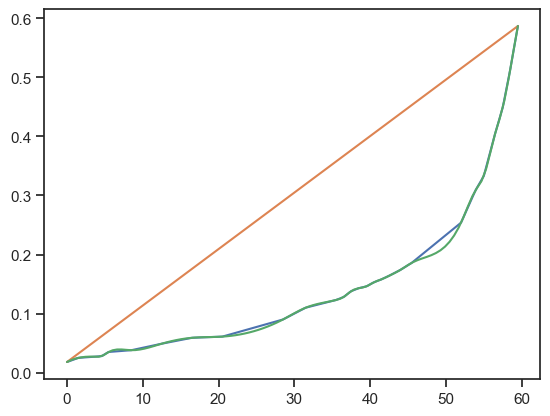

In [90]:
dfx = df_tubes.loc[(df_tubes['Strain abbrv.']=='aceE') & (df_tubes['Replicate']=='A')&df_tubes.OD600.notna()]
t = 60
x = dfx.loc[dfx['Time [h]']<t, 'Time [h]'].values
y = dfx.loc[dfx['Time [h]']<t, 'OD600'].values
print(t, y.max(), metrics.auc(x, y), scipy.integrate.simpson(y=y, x=x), t* (y.max()-y.min())/2)
plt.plot(x, y, label='aceE A')
plt.plot([0, x.max()],[y.min(), y.max()] )
yint = scipy.interpolate.interp1d(x,y, kind = 'cubic')
yint_x = np.linspace(0, x.max(), 100)
print(metrics.auc(yint_x, yint(yint_x)), scipy.integrate.simpson(y=yint(yint_x), x=yint_x))
plt.plot(yint_x, yint(yint_x), label='interp', c = 'g')

# Get exometabolome data

In [105]:
fn_exometabolome_nM = data_folder_1 / '3G_exometabolome_nM.csv'
df_nM = pd.read_csv(fn_exometabolome_nM)
df_nM.replace({'Concentration [nM]': {'ND':np.nan}}, inplace=True)
df_nM['Concentration [nM]'] = df_nM['Concentration [nM]'].astype(float)
df_nM['Label'] = df_nM['Strain'].map(label_mapping)



In [109]:
df_nM.columns

Index(['Strain', 'Replicate', 'Metabolite', 'Concentration [nM]', 'Label',
       'Concentration [nΜ]', 'Concentration [μΜ]'],
      dtype='object')

# Discard outliers

In [110]:
# SucB M7 isocitrate and citrate
idx_outliers = (df_nM['Strain'] =='sucB-M7')&(df_nM.Replicate == 'B')&(df_nM.Metabolite.isin(['Citrate', 'Isocitrate']))
df_nM.loc[idx_outliers, 'Concentration [nM]'] = np.nan

# sucB M5 and WT - Glutamine
idx_outliers = (df_nM['Metabolite']=='Glutamine')&(df_nM['Concentration [nM]']>300)
df_nM.loc[idx_outliers, 'Concentration [nM]'] = np.nan

# # Adenosine - remove outliers (leave this in)
# idx_outliers = (df_nM['Metabolite']=='Adenosine')&(df_nM.Strain=='sucB-M5')&(df_nM.Replicate=='A')
# df_nM.loc[idx_outliers, 'Concentration [nΜ]'] = np.nan
df_nM['Concentration [μΜ]'] = df_nM['Concentration [nM]']/1000


In [112]:
for i, row in df_nM.iterrows():
    strain = row['Strain']
    rep = row['Replicate']
    met = row['Metabolite']
    auc_gdw = auc_df.loc[(auc_df['Strain abbrv.'] == strain) & (auc_df['Replicate'] == rep), 'AUC [gDW/L*h]'].values[0]
    df_nM.at[i, 'AUC [gDW/L*h]'] = auc_gdw
df_nM['Rate [mmol/gDW/h]'] = df_nM['Concentration [μΜ]']*1e-3 / df_nM['AUC [gDW/L*h]']


# Save exometabolome_data

In [113]:
fn_exometabolome_nM_updated = data_folder_1 / '3I_exometabolome_rates.csv'
df_nM.to_csv(fn_exometabolome_nM_updated, index=False)
# df_nM.to_csv(fn_exometabolome_nM, index=False)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:7.090e-03 t=8.056e+00
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:2.370e-03 t=-1.900e+01
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:2.305e-05 t=4.593e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔaceE vs. ΔaceE-M2: Welch's t-test independent samples, P_val:7.797e-03 t=-9.663e+00
ΔaceE vs. ΔaceE-M3: Welch's t-test independent samples, P_val:4.342e-03 t=-1.513e+01
ΔaceE vs. ΔaceE-M4: Welch's t-test independent samples, P_val:4.091e-03 t=-1.559e+01


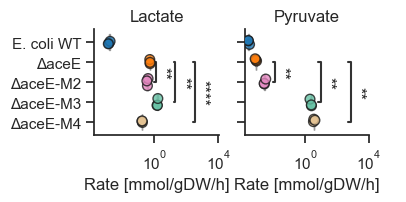

In [81]:
aceE_abbrv = ['WT', 'aceE', 'aceE-M2', 'aceE-M3', 'aceE-M4']

aceE_mets = ['Lactate', 'Pyruvate', 'Valine','Fructose-6-phosphate']
aceE_mets_main = ['Lactate', 'Pyruvate']
idx = (df_nM['Strain'].isin(aceE_abbrv))&(df_nM['Metabolite'].isin(aceE_mets_main))

g = sns.catplot(data = df_nM.loc[idx], y = 'Label', x = 'Rate [mmol/gDW/h]', 
            # hue = 'Label', 
            col = 'Metabolite', kind = 'box',
            # palette = strains_cmap, 
            color = 'w',
            height = 2.1, aspect = 1, col_wrap=2, sharex=True,
            col_order=aceE_mets_main, order = [label_mapping[x] for x in aceE_abbrv])
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
g.map_dataframe(sns.stripplot, x = 'Rate [mmol/gDW/h]', y = 'Label',
                hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
                jitter=0.2)

# Set logarithmic scale for the x-axis and remove minor ticks
for ax in g.axes.flat:
    ax.set_xscale('log')  # Set log scale
    ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    
    # ax.set_xlabel('')
    # ax.set_xlim(0.1, )
# g.figure.supxlabel('Rate [mmol/gDW/h]', fontsize=12)

# Define pairs of groups to compare
pairs = [
    ("ΔaceE", "ΔaceE-M2"),
    ("ΔaceE", "ΔaceE-M3"),
    ("ΔaceE", "ΔaceE-M4"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, aceE_mets_main):
    data = df_nM.loc[(df_nM["Metabolite"] == metabolite) & idx]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Rate [mmol/gDW/h]",
                           orient = 'h', order=[label_mapping[x] for x in aceE_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()
    
# plt.show()
plt.savefig(figure_folder / 'aceE_main_exometabolome_rate.pdf', bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:7.709e-01 t=3.255e-01
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:1.768e-01 t=-1.751e+00
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:4.407e-01 t=-9.516e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ΔsucB vs. ΔsucB-M5: Welch's t-test independent samples, P_val:9.170e-03 t=5.075e+00
ΔsucB vs. ΔsucB-M6: Welch's t-test independent samples, P_val:5.750e-03 t=-5.392e+00
ΔsucB vs. ΔsucB-M7: Welch's t-test independent samples, P_val:3.138e-01 t=-1.316e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1

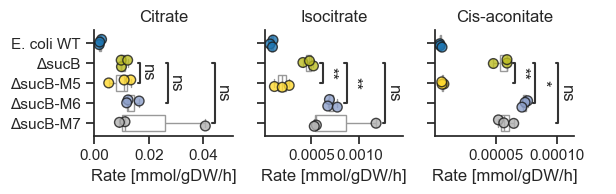

In [82]:
sucB_abbrv = ['WT', 'sucB', 'sucB-M5', 'sucB-M6', 'sucB-M7']

sucB_mets = ['Citrate', 'Isocitrate', 'Cis-aconitate','Adenosine', 'Glutamine']
sucB_mets_main = ['Citrate', 'Isocitrate', 'Cis-aconitate']
idx = (df_nM['Strain'].isin(sucB_abbrv))&(df_nM['Metabolite'].isin(sucB_mets_main))

g = sns.catplot(data = df_nM.loc[idx], y = 'Label', x = 'Rate [mmol/gDW/h]', 
            # hue = 'Label', 
            col = 'Metabolite', kind = 'box',
            # palette = strains_cmap, 
            color = 'w',
            height = 2.1, aspect = 1, col_wrap=3, sharex=False,
            col_order=sucB_mets_main, order = [label_mapping[x] for x in sucB_abbrv])
g.set_titles("{col_name}", size = 12)  # Sets titles to only display the strain name
g.map_dataframe(sns.stripplot, x = 'Rate [mmol/gDW/h]', y = 'Label',
                hue = 'Label', palette = strains_cmap, alpha = 0.8, size = 7, edgecolor='k', linewidth = 1,
                jitter=0.2)

# Set logarithmic scale for the x-axis and remove minor ticks
for ax in g.axes.flat:
    # ax.set_xscale('log')  # Set log scale
    ax.tick_params(which='minor', bottom=False, left=False)  # Remove minor ticks
    ax.set_ylabel('')
    # ax.set_xlabel('')
# g.figure.supxlabel('Rate [mmol/gDW/h]', fontsize=12)
    
# Define pairs of groups to compare
pairs = [
    ("ΔsucB", "ΔsucB-M5"),
    ("ΔsucB", "ΔsucB-M6"),
    ("ΔsucB", "ΔsucB-M7"),
]

# Add statistical annotations
for ax, metabolite in zip(g.axes.flat, sucB_mets_main):
    data = df_nM.loc[(df_nM["Metabolite"] == metabolite) & idx]
    annotator = Annotator(ax, pairs, data=data, y="Label", x="Rate [mmol/gDW/h]",
                           orient = 'h', order=[label_mapping[x] for x in sucB_abbrv])
    annotator.configure(test="t-test_welch", text_format="star", loc="inside", verbose=1,
                        text_offset=0.1, line_offset=0.2, line_height=0.02)
    # annotator.configure(test="Kruskal", text_format="star", loc="inside", verbose=2)
    annotator.apply_and_annotate()
    
# plt.show()
plt.savefig(figure_folder / 'sucB_main_exometabolome_rate.pdf', bbox_inches='tight')